In [377]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, filters, morphology, measure, img_as_ubyte
from skimage.color import rgba2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, clear_border

from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes



In [656]:
import pydicom
import numpy as np
import os

def load_dicom_series(folder_path):
    
    dicom_files = []

    # Load DICOM files from folder
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            try:
                dicom_files.append(pydicom.dcmread(filepath))
            except Exception as e:
                print(f"⚠️ Warning: Could not read {filename} - {e}")

    if not dicom_files:
        raise ValueError("❌ No valid DICOM files found in the folder.")

    # Try sorting by ImagePositionPatient if available
    try:
        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        print("⚠️ ImagePositionPatient not found. Using default order.")

    # Stack images into a 3D NumPy array
    volume = np.stack([file.pixel_array for file in dicom_files])

    # Extract voxel spacing
    try:
        slice_thickness = float(dicom_files[0].SliceThickness)
    except AttributeError:
        slice_thickness = 1.0  # Default value if missing
        print("⚠️ SliceThickness not found. Using default value of 1.0.")

    try:
        pixel_spacing = dicom_files[0].PixelSpacing
        spacing = (slice_thickness, float(pixel_spacing[0]), float(pixel_spacing[1]))
    except AttributeError:
        spacing = (slice_thickness, 1.0, 1.0)  # Default pixel spacing
        print("⚠️ PixelSpacing not found. Using default (1.0, 1.0).")

    print(f"Loaded DICOM series: {len(dicom_files)} slices")
    print(f"Volume shape: {volume.shape}")
    print(f"Voxel spacing: {spacing}")

    return volume, spacing, dicom_files

folder_path = "/Users/shimincheng/.cache/DCMDATA/SCD_IMAGES_01/SCD0000101/CINESAX_300"
volume, spacing, dicom_files = load_dicom_series(folder_path)

Loaded DICOM series: 240 slices
Volume shape: (240, 256, 256)
Voxel spacing: (10.0, 1.367188, 1.367188)


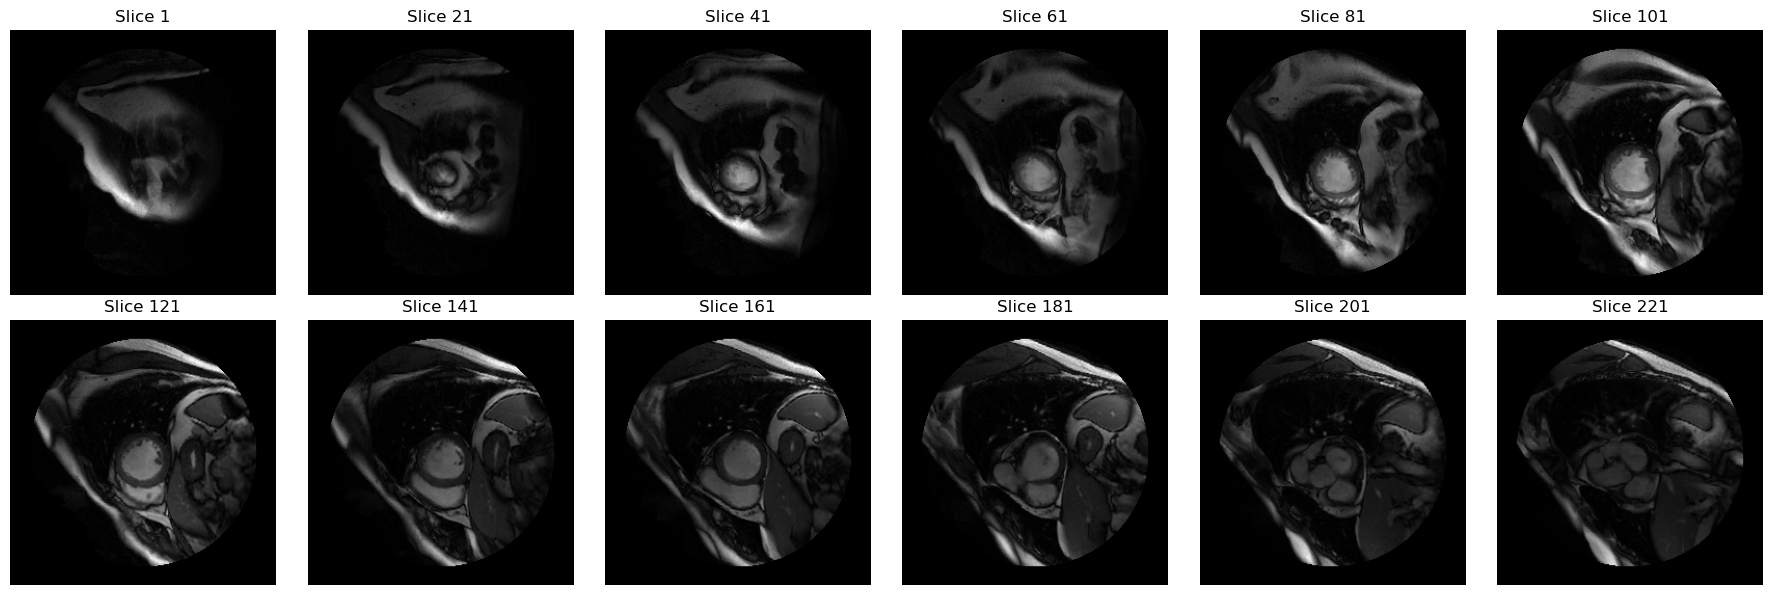

In [608]:
import matplotlib.pyplot as plt
import numpy as np

def show_slices(volume, num_columns=6, step=10):
    """
    Display selected DICOM slices in a grid format, skipping by a given step.

    Parameters:
    - volume (numpy array): 3D NumPy array containing the image stack.
    - num_columns (int): Number of columns in the figure (default: 6).
    - step (int): Step size to skip slices (default: 5).
    """
    slices = volume[::step]  # Extract slices at the given step
    num_slices = slices.shape[0]
    num_rows = int(np.ceil(num_slices / num_columns))  # Compute necessary rows

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))  # Adjust figure size

    for i in range(num_rows * num_columns):
        row, col = divmod(i, num_columns)  # Get row and column index
        

        if i < num_slices:
            img = slices[i]
            #if img.ndim == 3 and img.shape[-1] == 3:
                #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f"Slice {i * step + 1}", fontsize=12)  # Adjusted index
            axes[row, col].axis("off")
        else:
            axes[row, col].axis("off")  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# Example usage:
show_slices(volume, num_columns=6, step=20)

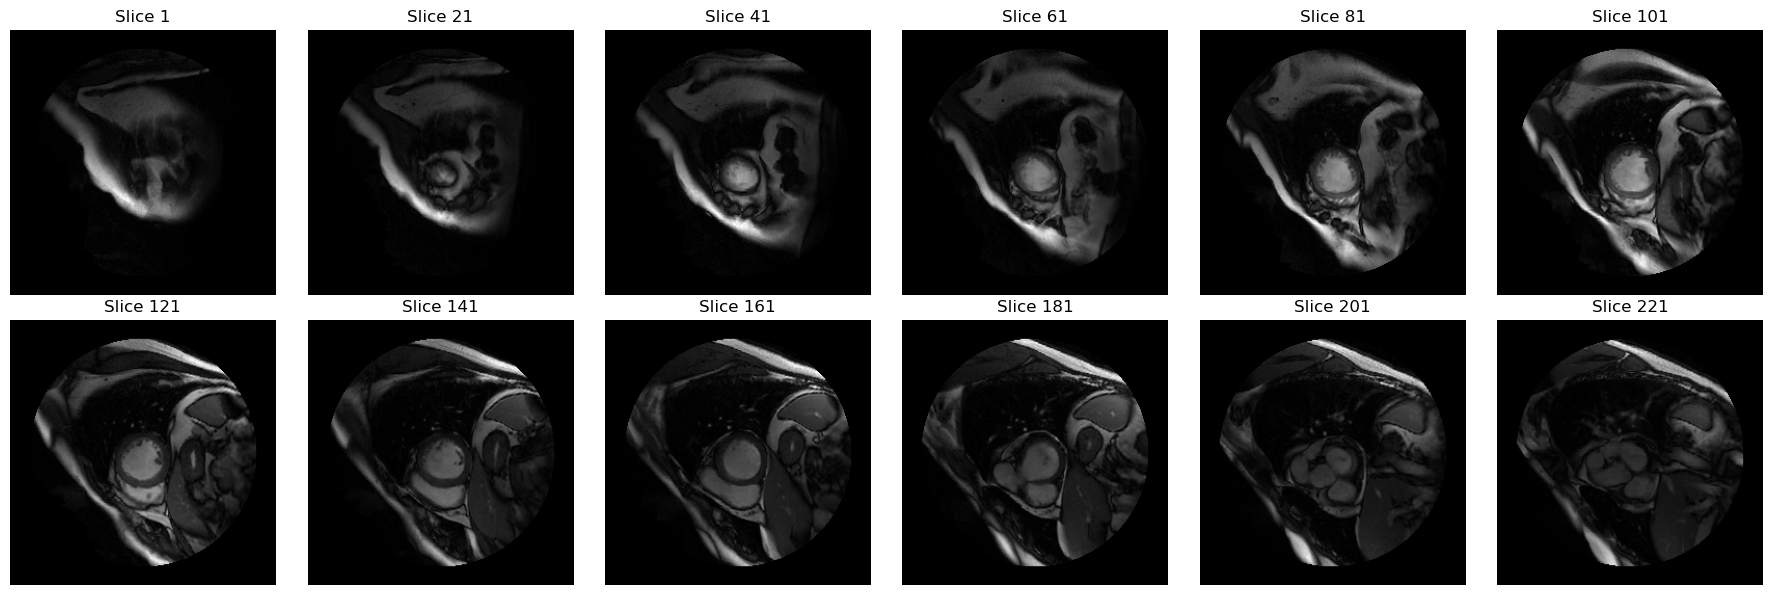

In [610]:
import numpy as np
import cv2

def convert_volume_to_grayscale(volume):
    """
    Convert a 3D volume to grayscale (if needed).

    Parameters:
    - volume: 3D NumPy array (D, H, W) or (D, H, W, C)

    Returns:
    - gray_volume: 3D NumPy array (D, H, W), grayscale version
    """
    gray_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]
        if img.ndim == 3 and img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_volume.append(img)

    return np.stack(gray_volume)


gray_volume = convert_volume_to_grayscale(volume)

show_slices(gray_volume, num_columns=6, step=20)

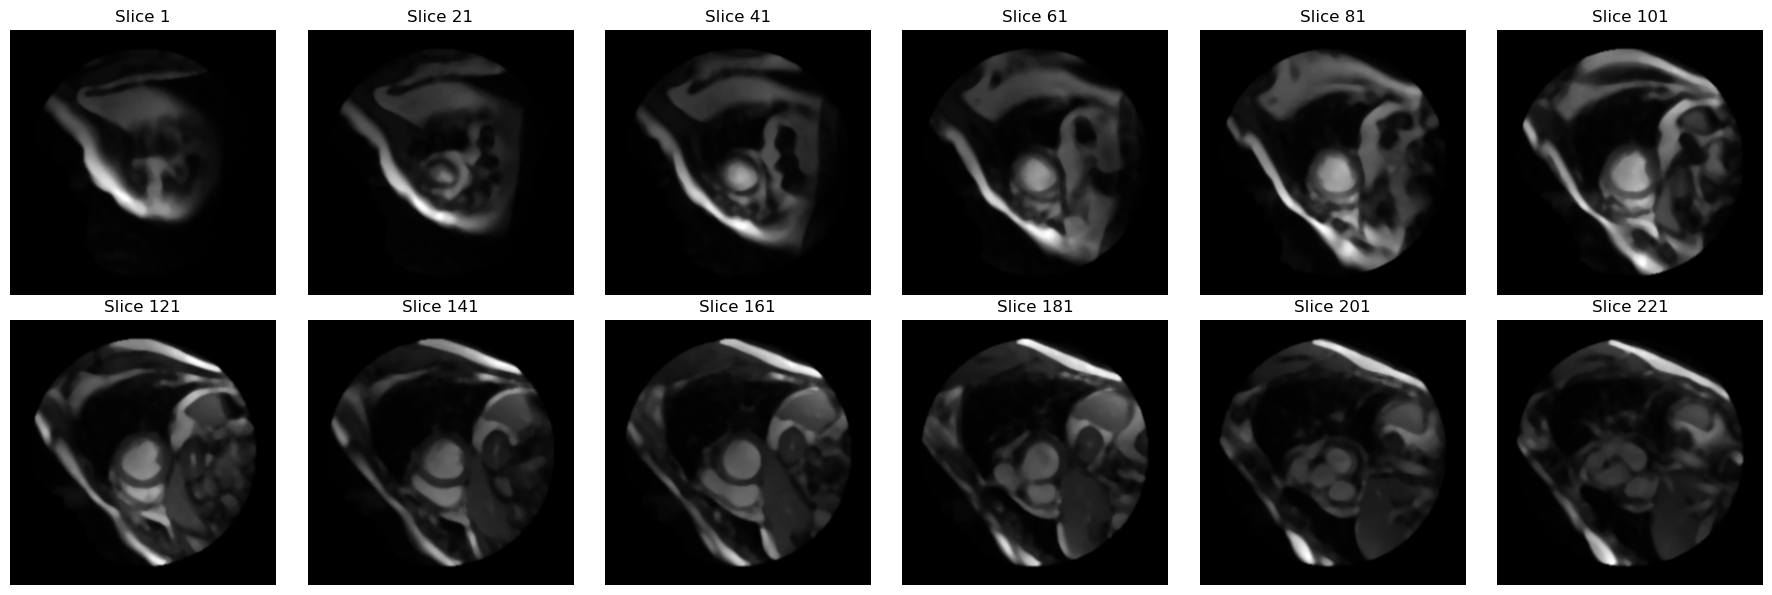

In [626]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def smoothed_volume(volume):
    gauss_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if img.dtype != np.uint8:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  
            img = img.astype(np.uint8)

        med = cv2.medianBlur(img, 7)
        gauss = cv2.GaussianBlur(med, (3, 3), 0)
        gauss_volume.append(gauss)

    return np.stack(gauss_volume)



smoothed = smoothed_volume(gray_volume)

show_slices(smoothed, num_columns=6, step=20)

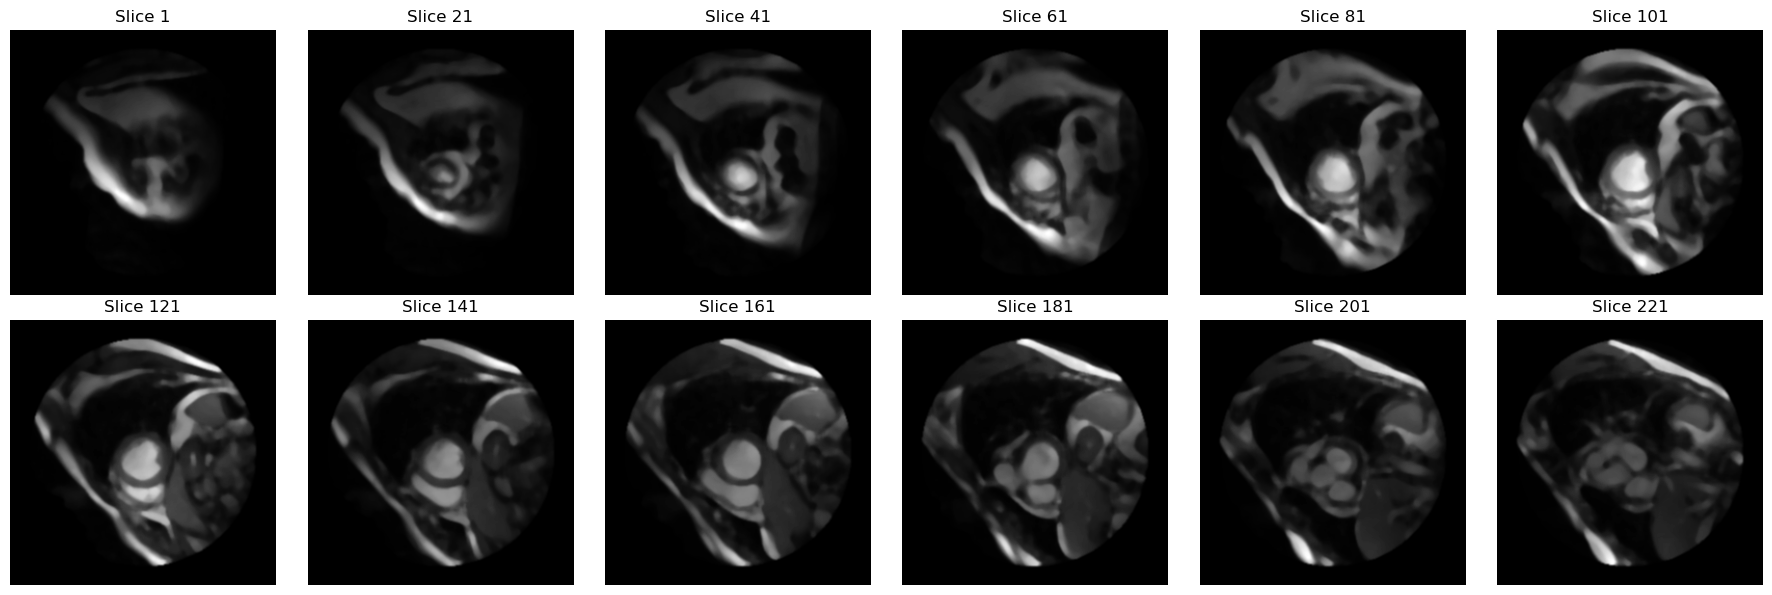

In [628]:
def center_weighted_volume(volume,alpha):
    weighted_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        # Center weighting
        h, w = img.shape
        yy, xx = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
        distance = np.sqrt(xx**2 + yy**2)
        weight_map = np.exp(-4 * distance**2)
        img_weighted = img * (1 + alpha * weight_map)
        weighted_volume.append(img_weighted)

    return np.stack(weighted_volume)



weighted = center_weighted_volume(smoothed,alpha=0.5)

show_slices(weighted, num_columns=6, step=20)

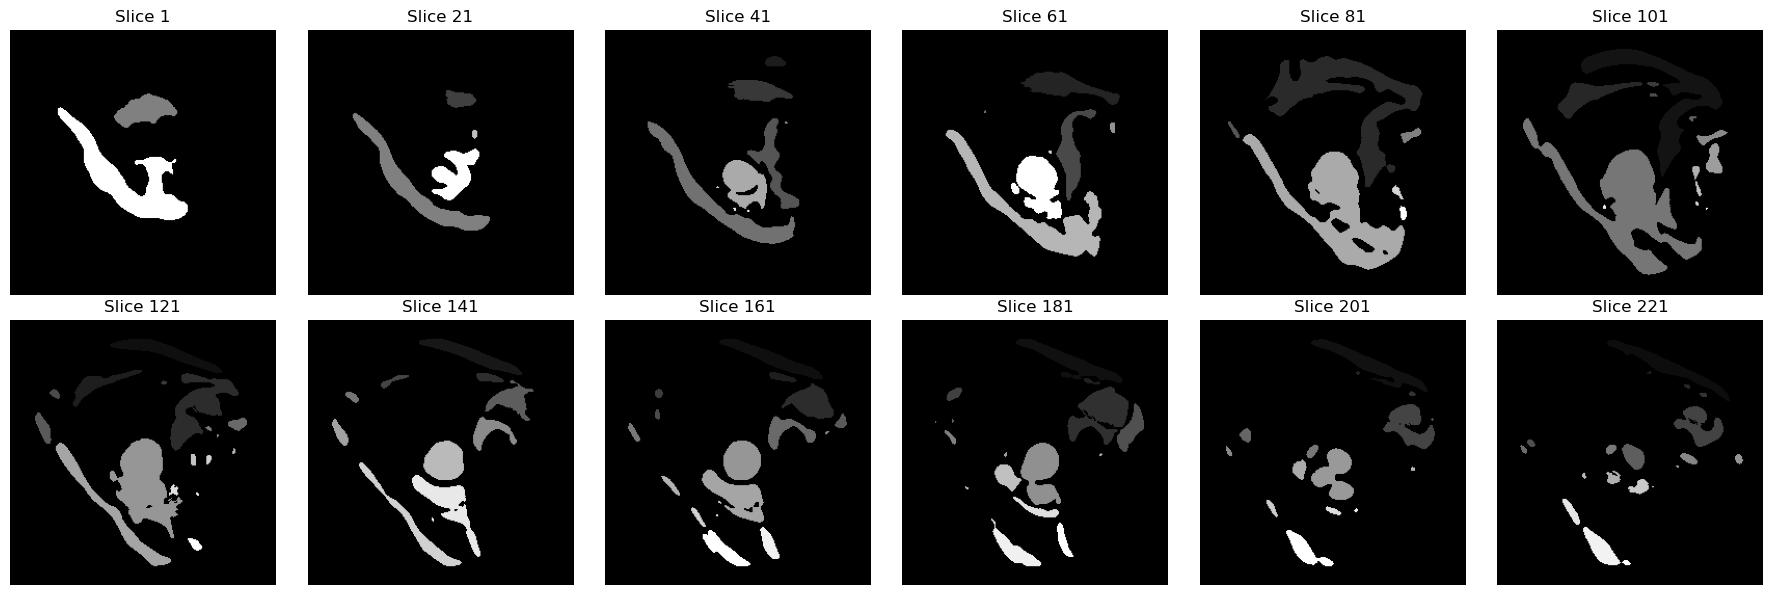

In [644]:
def threshed_volume(volume, manual_thresh):
    threshed_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if manual_thresh > 0:
            thresh = manual_thresh
        else:
            thresh = threshold_otsu(img)  
        
        binary = img > thresh

        labeled = label(binary)
        cleaned = clear_border(labeled)
        threshed_volume.append(cleaned)

    return np.stack(threshed_volume)




threshed = threshed_volume(weighted,manual_thresh=60)

show_slices(threshed, num_columns=6, step=20)

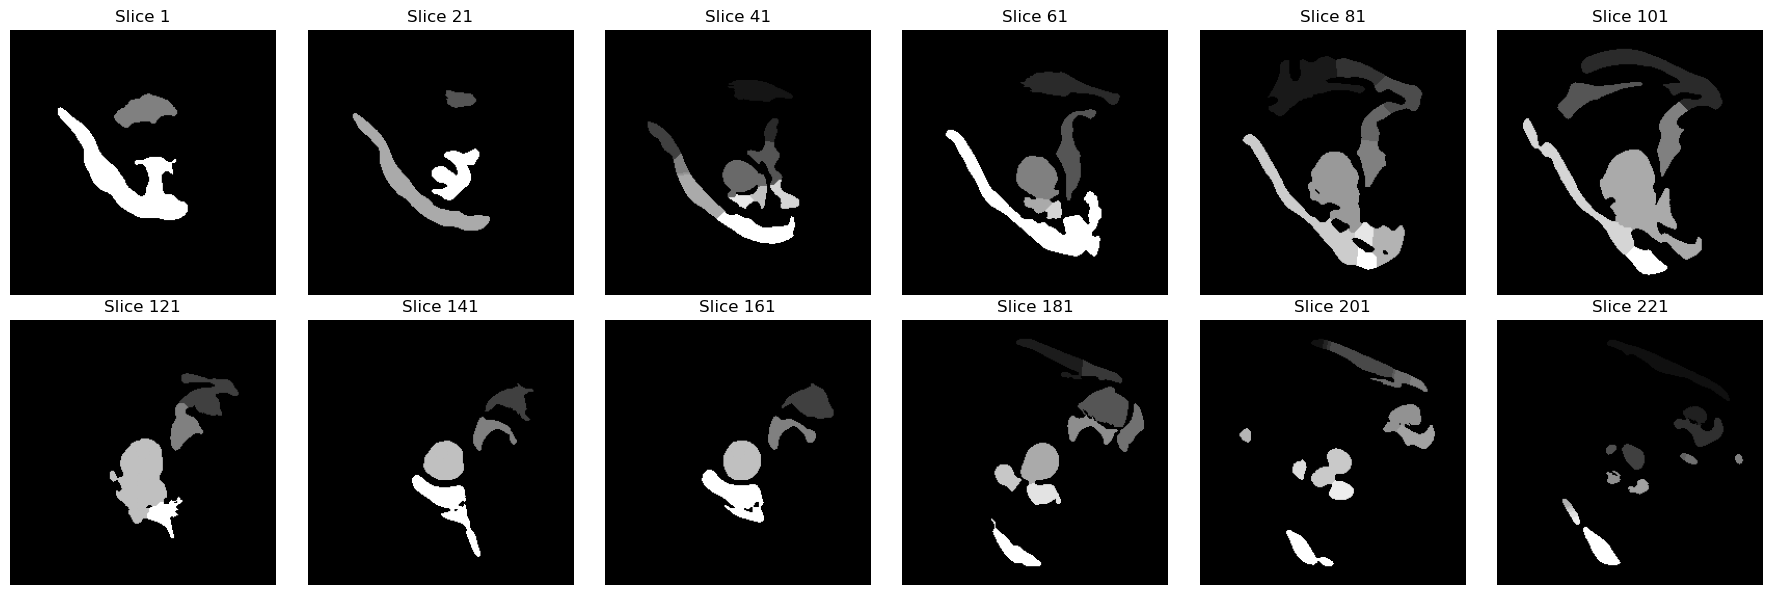

In [654]:
from skimage.segmentation import watershed
def watershed_volume(volume):
    watershed_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if np.sum(img) == 0:
            watershed_volume.append(np.zeros_like(img, dtype=np.int32))
            continue

        edges = sobel(img)
        distance_map = distance_transform_edt(img)
        
        seed_threshold = 0.4 * np.max(distance_map)
        seeds = distance_map > seed_threshold
        markers = label(seeds)
        
        labeled_mask = watershed(edges, markers, mask=img)
        watershed_volume.append(labeled_mask)

    return np.stack(watershed_volume)




watershed_result = watershed_volume(threshed)
show_slices(watershed_result, num_columns=6, step=20)